In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#This is a data set that I have already removed all the extreme outliers.
credit= pd.read_csv('clean_data.csv')
credit.head()

,Unnamed: 0,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,limit,sex,education,marriage,age
0,0,2,2,0,0,0,0,3913,3102,689,...,0,0,0,0,default,20000,female,university,1,24
1,1,0,2,0,0,0,2,2682,1725,2682,...,1000,1000,0,2000,default,120000,female,university,2,26
2,2,0,0,0,0,0,0,29239,14027,13559,...,1000,1000,1000,5000,not default,90000,female,university,2,34
3,3,0,0,0,0,0,0,46990,48233,49291,...,1200,1100,1069,1000,not default,50000,female,university,1,37
4,4,0,0,0,0,0,0,8617,5670,35835,...,10000,9000,689,679,not default,50000,male,university,1,57


In [3]:
credit.dtypes

Unnamed: 0     int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1      int64
BILL_AMT2      int64
BILL_AMT3      int64
BILL_AMT4      int64
BILL_AMT5      int64
BILL_AMT6      int64
PAY_AMT1       int64
PAY_AMT2       int64
PAY_AMT3       int64
PAY_AMT4       int64
PAY_AMT5       int64
PAY_AMT6       int64
default       object
limit          int64
sex           object
education     object
marriage       int64
age            int64
dtype: object

In [4]:
#Binning the ages into groups by decades. Age 60+ represented 1% of total customers so I have biggest group of 50+
bins = [20,29,39,49,80]

credit['age_groups'] = pd.cut(credit['age'], bins=bins, labels =[20, 30,40,50]).astype('int64')

In [5]:
#I binned the credit limits. After a several attempts this gave me a 65% prediction rate
bins = [9999, 160000 ,300000,600000]
credit['limit_groups'] = pd.cut(credit['limit'],bins=bins, labels=[10,160,300]).astype('int64')
credit['limit_groups'].value_counts(sort=True)

10     17079
160     8331
300     4476
Name: limit_groups, dtype: int64

In [6]:
credit_binned = credit.drop('Unnamed: 0', axis=1)
credit_binned.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,...,PAY_AMT5,PAY_AMT6,default,limit,sex,education,marriage,age,age_groups,limit_groups
0,2,2,0,0,0,0,3913,3102,689,0,...,0,0,default,20000,female,university,1,24,20,10
1,0,2,0,0,0,2,2682,1725,2682,3272,...,0,2000,default,120000,female,university,2,26,20,10
2,0,0,0,0,0,0,29239,14027,13559,14331,...,1000,5000,not default,90000,female,university,2,34,30,10
3,0,0,0,0,0,0,46990,48233,49291,28314,...,1069,1000,not default,50000,female,university,1,37,30,10
4,0,0,0,0,0,0,8617,5670,35835,20940,...,689,679,not default,50000,male,university,1,57,50,10


In [7]:
credit_binned.dtypes


PAY_0            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1        int64
BILL_AMT2        int64
BILL_AMT3        int64
BILL_AMT4        int64
BILL_AMT5        int64
BILL_AMT6        int64
PAY_AMT1         int64
PAY_AMT2         int64
PAY_AMT3         int64
PAY_AMT4         int64
PAY_AMT5         int64
PAY_AMT6         int64
default         object
limit            int64
sex             object
education       object
marriage         int64
age              int64
age_groups       int64
limit_groups     int64
dtype: object

In [8]:
#Encode as needed
le = LabelEncoder()
le.fit(credit_binned['sex'])
credit_binned['sex']=le.transform(credit_binned['sex'])
credit_binned['sex'].value_counts()

0    18047
1    11839
Name: sex, dtype: int64

In [9]:
le = LabelEncoder()
le.fit(credit_binned['default'])
credit_binned['default'] = le.transform(credit_binned['default'])
credit_binned['default'].value_counts()

1    23262
0     6624
Name: default, dtype: int64

In [26]:
credit_binned.head()

,PAY_0,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_AMT5,PAY_AMT6,default,limit,sex,education,marriage,age,age_groups,limit_groups
0,2,3913,3102,689,0,0,0,0,689,0,...,0,0,0,20000,0,2,1,24,20,10
1,0,2682,1725,2682,3272,3455,3261,0,1000,1000,...,0,2000,0,120000,0,2,2,26,20,10
2,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,...,1000,5000,1,90000,0,2,2,34,30,10
3,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,...,1069,1000,1,50000,0,2,1,37,30,10
4,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,...,689,679,1,50000,1,2,1,57,50,10


In [10]:
credit_binned["education"].replace({"high school": 1, "university": 2, "graduate school": 3, 'other':0}, inplace=True)

In [11]:
credit_binned=credit_binned.drop(['PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'], axis=1)

In [12]:
credit_binned.dtypes

PAY_0           int64
BILL_AMT1       int64
BILL_AMT2       int64
BILL_AMT3       int64
BILL_AMT4       int64
BILL_AMT5       int64
BILL_AMT6       int64
PAY_AMT1        int64
PAY_AMT2        int64
PAY_AMT3        int64
PAY_AMT4        int64
PAY_AMT5        int64
PAY_AMT6        int64
default         int32
limit           int64
sex             int32
education       int64
marriage        int64
age             int64
age_groups      int64
limit_groups    int64
dtype: object

In [13]:
credit_binned.corr()

,PAY_0,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_AMT5,PAY_AMT6,default,limit,sex,education,marriage,age,age_groups,limit_groups
PAY_0,1.000000,0.001616,0.011568,0.015462,0.024436,0.033296,0.032855,-0.079513,-0.057511,-0.064365,...,-0.054484,-0.047833,-0.395995,-0.171195,0.034990,-0.056170,-0.011628,-0.001018,-0.001803,-0.155750
BILL_AMT1,0.001616,1.000000,0.950887,0.891523,0.859156,0.829029,0.801752,0.137388,0.099100,0.140493,...,0.166864,0.175355,0.018455,0.277678,0.033662,-0.018223,-0.023947,0.054285,0.049756,0.235253
BILL_AMT2,0.011568,0.950887,1.000000,0.927858,0.890929,0.858567,0.830250,0.280876,0.100438,0.132542,...,0.157417,0.169587,0.012956,0.271303,0.031603,-0.013534,-0.022319,0.052525,0.047843,0.229703
BILL_AMT3,0.015462,0.891523,0.927858,1.000000,0.923314,0.883950,0.853366,0.241359,0.316943,0.121169,...,0.175190,0.178565,0.012834,0.276650,0.024589,-0.008189,-0.026116,0.052191,0.047317,0.234857
BILL_AMT4,0.024436,0.859156,0.890929,0.923314,1.000000,0.940241,0.900529,0.229089,0.205525,0.290664,...,0.153763,0.173217,0.008822,0.287243,0.022115,0.004028,-0.024455,0.049678,0.044740,0.246634
BILL_AMT5,0.033296,0.829029,0.858567,0.883950,0.940241,1.000000,0.945089,0.213083,0.178771,0.238746,...,0.133924,0.159420,0.005150,0.288239,0.017146,0.010821,-0.026257,0.048021,0.042132,0.247964
BILL_AMT6,0.032855,0.801752,0.830250,0.853366,0.900529,0.945089,1.000000,0.195194,0.169997,0.217066,...,0.304782,0.109522,0.003822,0.281918,0.016970,0.010539,-0.022089,0.046342,0.039476,0.240665
PAY_AMT1,-0.079513,0.137388,0.280876,0.241359,0.229089,0.213083,0.195194,1.000000,0.280578,0.249227,...,0.125417,0.178113,0.072660,0.192374,0.000257,0.040463,-0.006993,0.026308,0.024187,0.179044
PAY_AMT2,-0.057511,0.099100,0.100438,0.316943,0.205525,0.178771,0.169997,0.280578,1.000000,0.255566,...,0.169235,0.158129,0.058286,0.177164,0.001583,0.032232,-0.008696,0.021711,0.022154,0.158439
PAY_AMT3,-0.064365,0.140493,0.132542,0.121169,0.290664,0.238746,0.217066,0.249227,0.255566,1.000000,...,0.151752,0.158071,0.057798,0.208282,0.009796,0.043724,-0.002564,0.027914,0.028409,0.187331


In [14]:
X = credit_binned.drop(['age','limit','default'], axis=1)
y = credit_binned['default']

In [15]:
algos_Class = []
algos_Class.append(('Random Forest Classifier',RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier',DecisionTreeClassifier()))

In [16]:
#classificaiton
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X,y, cv = 4, scoring = 'accuracy')
    names.append(name)
    results.append(result)

In [17]:
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier 0.814830294375941
Decision Tree Classifier 0.72214480036584


In [18]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                test_size = .2, random_state =123)

In [19]:
#Modeling (Classification)
algo = DecisionTreeClassifier(max_depth = 5, random_state = 123)
model = algo.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [20]:
#Predictions
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.34      0.46      1351
           1       0.83      0.96      0.89      4627

    accuracy                           0.82      5978
   macro avg       0.77      0.65      0.67      5978
weighted avg       0.80      0.82      0.79      5978



In [21]:
import pydot
import matplotlib.image as mping
import io
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
import matplotlib as mpl
import graphviz
import pydotplus

C:\conda\envs\sherri\lib\site-packages\sklearn\externals\six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


In [22]:
labels =['default', 'not default']

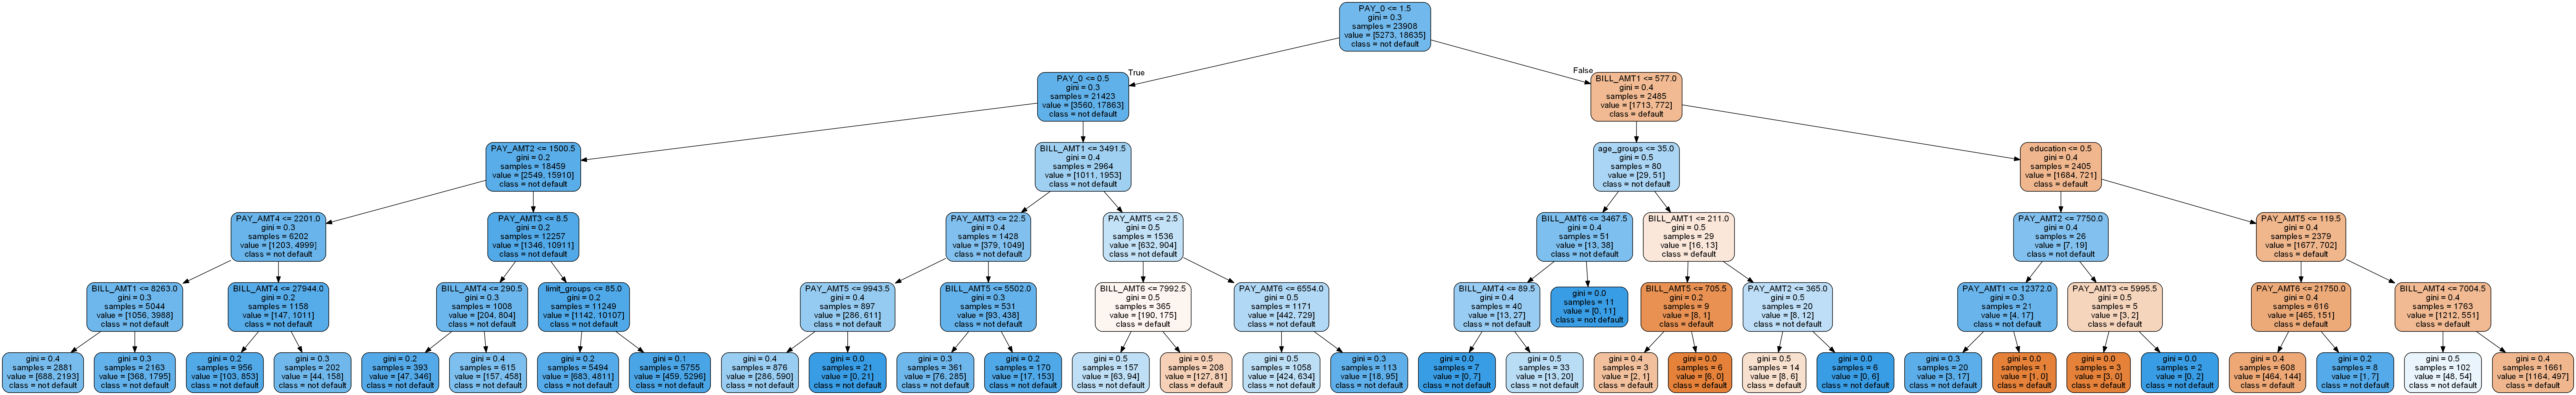

In [23]:
dot_data = StringIO()
export_graphviz(model, out_file = dot_data, filled = True, rounded=True,
                feature_names = X.columns, class_names=labels, 
                precision=1,label='all')
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())
graph.set_size('"100,100!"')
Image(graph.create_png())

In [24]:
#Modeling (Classification) Using Random Forest
algo = RandomForestClassifier(n_estimators=250, max_depth=15,random_state = 123)
model = algo.fit(X_train, y_train)
print(model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


In [25]:
#Predictions
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.35      0.47      1351
           1       0.83      0.96      0.89      4627

    accuracy                           0.82      5978
   macro avg       0.77      0.65      0.68      5978
weighted avg       0.80      0.82      0.80      5978

